In [48]:
import pandas as pd
import numpy as np
from glob import glob
import os

In [2]:
TUBS_PATH='/home/af1n/work/robocar/donkey-categorical/tub2'
MODEL_SAVE_PATH='/tmp/best_model.h5'

In [17]:
# Load all records from tubes
# A single record is a JSON file containing path to the camera image and steering angle of the car when the
# camera image was acquired.

record_files=glob(os.path.join(TUBS_PATH,"*","record*.json"))
records=pd.DataFrame(record_files, columns=['record_path'])
records=pd.concat([records, records.apply(lambda path: pd.read_json(path_or_buf=path['record_path'], typ='series'),axis=1)], axis=1)
records['cam/image_array']=records.apply(lambda s: os.path.join(os.path.dirname(s['record_path']), s['cam/image_array']), axis=1)
records.head(10)

,record_path,cam/image_array,timestamp,user/angle,user/mode,user/throttle
0,/home/af1n/work/robocar/donkey-categorical/tub...,/home/af1n/work/robocar/donkey-categorical/tub...,None,0.000000,user,0.896939
1,/home/af1n/work/robocar/donkey-categorical/tub...,/home/af1n/work/robocar/donkey-categorical/tub...,None,1.000000,user,1.000000
2,/home/af1n/work/robocar/donkey-categorical/tub...,/home/af1n/work/robocar/donkey-categorical/tub...,None,0.907224,user,0.721702
3,/home/af1n/work/robocar/donkey-categorical/tub...,/home/af1n/work/robocar/donkey-categorical/tub...,None,-0.938200,user,0.783532
4,/home/af1n/work/robocar/donkey-categorical/tub...,/home/af1n/work/robocar/donkey-categorical/tub...,None,0.000000,user,0.649525
5,/home/af1n/work/robocar/donkey-categorical/tub...,/home/af1n/work/robocar/donkey-categorical/tub...,None,0.000000,user,0.731986
6,/home/af1n/work/robocar/donkey-categorical/tub...,/home/af1n/work/robocar/donkey-categorical/tub...,None,0.000000,user,1.000000
7,/home/af1n/work/robocar/donkey-categorical/tub...,/home/af1n/work/robocar/donkey-categorical/tub...,None,0.000000,user,1.000000
8,/home/af1n/work/robocar/donkey-categorical/tub...,/home/af1n/work/robocar/donkey-categorical/tub...,None,0.000000,user,0.783532
9,/home/af1n/work/robocar/donkey-categorical/tub...,/home/af1n/work/robocar/donkey-categorical/tub...,None,-1.000000,user,0.752617


In [18]:
samples=records[['cam/image_array', 'user/angle']]
samples.columns=['img', 'angle']
samples.head(10)

,img,angle
0,/home/af1n/work/robocar/donkey-categorical/tub...,0.000000
1,/home/af1n/work/robocar/donkey-categorical/tub...,1.000000
2,/home/af1n/work/robocar/donkey-categorical/tub...,0.907224
3,/home/af1n/work/robocar/donkey-categorical/tub...,-0.938200
4,/home/af1n/work/robocar/donkey-categorical/tub...,0.000000
5,/home/af1n/work/robocar/donkey-categorical/tub...,0.000000
6,/home/af1n/work/robocar/donkey-categorical/tub...,0.000000
7,/home/af1n/work/robocar/donkey-categorical/tub...,0.000000
8,/home/af1n/work/robocar/donkey-categorical/tub...,0.000000
9,/home/af1n/work/robocar/donkey-categorical/tub...,-1.000000


In [19]:
def linear_bin(a):
    """
    Convert a value to a categorical array.
    Taken from donkeycar util/data.py

    Parameters
    ----------
    a : int or float
        A value between -1 and 1

    Returns
    -------
    list of int
        A list of length 15 with one item set to 1, which represents the linear value, and 
all other items set to 0.
    """
    a = a + 1
    b = round(a / (2 / 14))
    arr = np.zeros(15)
    arr[int(b)] = 1
    return str(arr.tolist())

classes=[linear_bin(x) for x in np.arange(-1,1.1,2/14)]
classes

['[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]',
 '[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]',
 '[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]',
 '[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]',
 '[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]',
 '[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]',
 '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]',
 '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]',
 '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]',
 '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]',
 '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]',
 '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]',
 '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [20]:
samples_categorical = pd.DataFrame(samples)
samples_categorical['angle'] = samples['angle'].apply(lambda x: linear_bin(x))
samples_categorical.head(10)
samples_categorical['img'].iloc[0]

'/home/af1n/work/robocar/donkey-categorical/tub2/20180910_pinkpony_tub_hella_cw/1627_cam-image_array_.jpg'

In [100]:
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.models import Model, Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

In [22]:
IMAGE_INPUT_WIDTH=160
IMAGE_INPUT_HEIGHT=120
# This discards number of pixels from the top after scaling
TOP_MARGIN_IN_PIXELS=120-72

In [104]:
model = Sequential()

#model.add(Cropping2D(cropping=((TOP_MARGIN_IN_PIXELS,0),(0,0)), input_shape=(IMAGE_INPUT_WIDTH, IMAGE_INPUT_HEIGHT,3)))
#model.add(Convolution2D(24, (5, 5), strides=(2,2), activation='relu', padding='same'))

model.add(Convolution2D(24, (5, 5), strides=(2,2), activation='relu', padding='same', input_shape=(IMAGE_INPUT_WIDTH, IMAGE_INPUT_HEIGHT,3)))
model.add(Convolution2D(32, (5, 5), strides=(2,2), activation='relu', padding='same'))
model.add(Convolution2D(64, (5, 5), strides=(2,2), activation='relu', padding='same'))
model.add(Convolution2D(64, (3, 3), strides=(2,2), activation='relu', padding='same'))
model.add(Convolution2D(64, (3, 3), strides=(2,2), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(100, activation='linear'))
model.add(Dropout(rate=.1))
model.add(Dense(50, activation='linear'))
model.add(Dropout(rate=.1))
model.add(Dense(15, activation='linear'))

model.compile(optimizers.rmsprop(lr=2, decay=0.5), loss="categorical_crossentropy", metrics=["accuracy"])
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='acc', patience=10),
             ModelCheckpoint(filepath=MODEL_SAVE_PATH, monitor='acc', save_best_only=True)]



In [ ]:
# Augumenting data slows down training
# datagen=ImageDataGenerator(rotation_range=15, width_shift_range=0.5, height_shift_range=0.05)
datagen=ImageDataGenerator()
train_generator=datagen.flow_from_dataframe(dataframe=samples, x_col="img", y_col="angle", class_mode="categorical", classes=classes, target_size=(IMAGE_INPUT_WIDTH,IMAGE_INPUT_HEIGHT), batch_size=32)
model.fit_generator(callbacks=callbacks, generator=train_generator, steps_per_epoch=1000, epochs=10)

Found 2643 validated image filenames belonging to 15 classes.
Epoch 1/10
1000/1000 [==============================] - 49s 49ms/step - loss: 7.9161 - acc: 0.4940
Epoch 2/10
1000/1000 [==============================] - 46s 46ms/step - loss: 7.1478 - acc: 0.4949
Epoch 3/10
 784/1000 [======================>.......] - ETA: 9s - loss: 6.8402 - acc: 0.4951

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

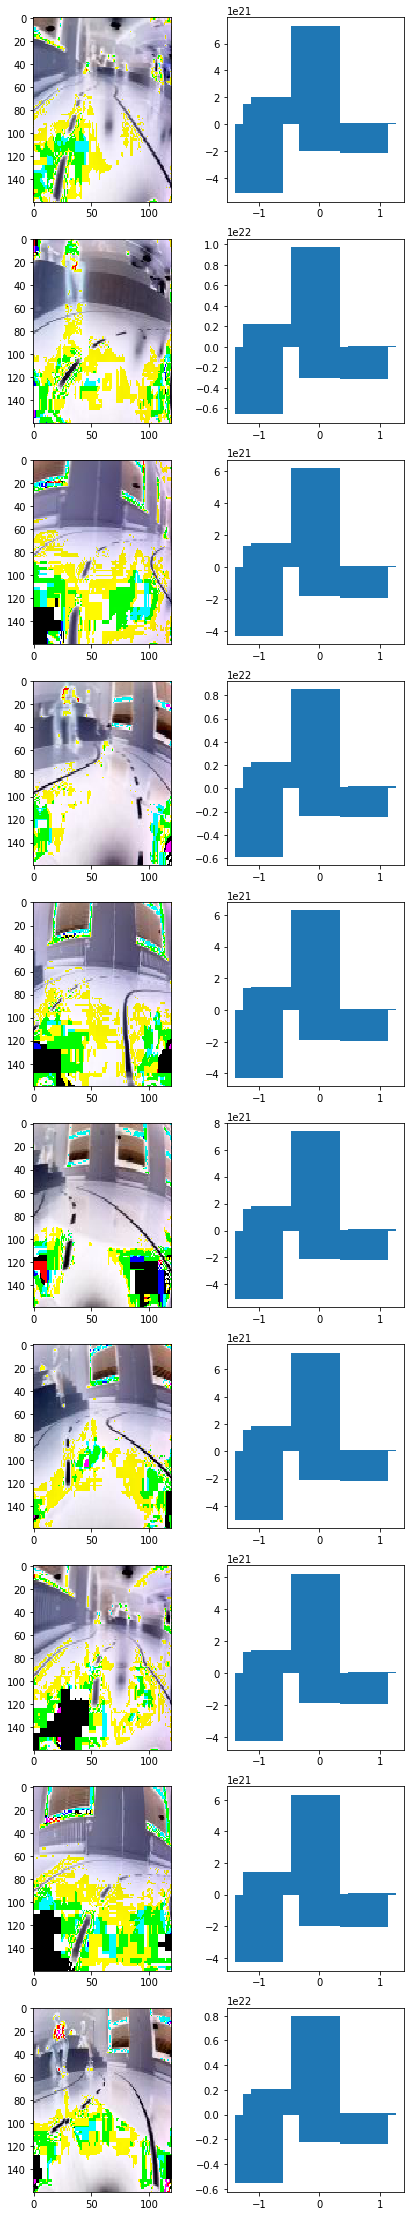

In [95]:
images=next(train_generator)[0]
predictions=model.predict(images)

fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(7,40))
rowid=0
for row in ax:
    row[0].imshow(images[rowid])
    row[1].bar(np.arange(-1,1,2/15), predictions[rowid])
    rowid=rowid+1